In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import pickle as pkl
import pylab as plt
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, MiniBatchKMeans
from sklearn import manifold
from sklearn.decomposition import TruncatedSVD, PCA, NMF, SparsePCA
import matplotlib.cm as cm
%matplotlib inline

In [6]:
df = pd.read_csv('005_dir_9k_texts.csv')

In [8]:
df['PMC'] = df['PMC'].astype('int64')

In [9]:
df

,Unnamed: 0,Full_text,PMC
0,0,"5239798.txt"", "" ==== Front Front MicrobiolFron...",5239798
1,1,"5218481.txt"", "" ==== Front PLoS OnePLoS ONEplo...",5218481
2,2,"5862454.txt"", "" ==== Front PLoS OnePLoS ONEplo...",5862454
3,3,"5622781.txt"", "" ==== Front NutrientsNutrientsn...",5622781
4,4,"5806876.txt"", "" ==== Front PLoS OnePLoS ONEplo...",5806876
...,...,...,...
256,256,"5682260.txt"", "" ==== Front Vet WorldVet WorldV...",5682260
257,257,"5741668.txt"", "" ==== Front Front ChemFront Che...",5741668
258,258,"5770358.txt"", "" ==== Front Front Plant SciFron...",5770358
259,259,"5600385.txt"", "" ==== Front PLoS Negl Trop DisP...",5600385


In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1,6))
matrix = vectorizer.fit_transform(df.Full_text)
matrix.shape

(261, 6529512)

In [7]:
#print (matrix[3])

In [8]:
#vectorizer.get_feature_names()

## data preprocessing

In [11]:
import re

def preprocess_text(sen):
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [12]:
texts = []
sentences = list(df["Full_text"])
for sen in sentences:
    texts.append(preprocess_text(sen))

In [13]:
df['new_texts_preprocessed']=texts

In [14]:
vectorizer = TfidfVectorizer(max_df=100, min_df=10, ngram_range=(1,5))
matrix = vectorizer.fit_transform(texts)
results_dense = matrix.toarray()
top_terms1 = []
for row in results_dense:
    scores = []
    for term, index in vectorizer.vocabulary_.items():    
        score = row[index]
        scores.append([term, score])
    df2 = pd.DataFrame.from_records(scores, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    df2 = df2.loc[df2['score'] > 0].reset_index(drop='True')
    terms = list(df2['term'])
    if len(terms) > 4:
        terms = terms[:4]
    top_terms1.append(terms)

top_terms1


[['streptomyces', 'oryzae', 'rice', 'biocontrol'],
 ['fructose', 'mannitol', 'lactobacillus', 'spot'],
 ['milk', 'intake', 'taxa', 'biofilm'],
 ['probiotics', 'probiotic', 'of probiotics', 'tl'],
 ['meat', 'eu', 'poultry', 'log cfu'],
 ['salmonella', 'cattle', 'serotypes', 'mdr'],
 ['campylobacter', 'poultry', 'cs', 'salmonella'],
 ['lactic acid', 'lactic acid bacteria', 'lactic', 'acid bacteria'],
 ['antioxidant', 'antioxidant activity', 'tryptophan', 'fraction'],
 ['glucan', 'il', 'colitis', 'inflammatory'],
 ['sucrose', 'utilization', 'pathway', 'the ce'],
 ['lactis', 'subsp', 'lab', 'mrs'],
 ['gut', 'microbiota', 'diet', 'gut microbiota'],
 ['pregnancy', 'otu', 'diet', 'pigs'],
 ['mammary', 'milk', 'microbiota', 'mastitis'],
 ['vibrio', 'ms', 'ms ms', 'lc ms'],
 ['insertions', 'cds', 'sub', 'insertion'],
 ['guinea', 'chicken', 'chickens', 'reads'],
 ['metagenome', 'thermophilic', 'community', 'communities'],
 ['tnd', 'wheat', 'volatile', 'fermentation'],
 ['poultry', 'meat', 'in po

In [15]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['cl','pbs','dpi','sa','ac','id','of co','in','gi','lc ms','ms','ms ms','mrs','ng ml','hp','ae','occur','followed','isolated','produce','produced','difference','differences','days','min','also','might','levels','rate','may','due' ,'several', 'described', 'important', 'non', 'first', 'observed', 'results', 'indicate', 'many','regions', 'type', 'including' ,'response', 'large' ,'reported', 'functional' ,'addition' ,'tested', 'component', 'fish' ,'assay', 'conditions', 'performed' ,'either' ,'role' ,'reports' ,'report', 'process','shown' ,'well', 'result', 'different' ,'analysis', 'day', 'contain', 'presence', 'likely', 'within', 'among', 'although', 'thus', 'form' ,'suggest' ,'mm','level', 'time', 'known', 'sample' ,'involved' ,'obtained', 'major', 'previously', 'growth', 'system', 'similar' ,'present', 'effect', 'based', 'identified', 'associated', 'containing', 'show', 'positive', 'negative', 'condition', 'region','compared' ,'specific' ,'study' ,'high', 'include','sp','found','showed','high','number','reduced','figure','table','fig','bcg ml','ce bcg ml','bcg','ml','et al','na','dr','il','from','can be','lab', 'hours','bcm','atcc','ce','gram','cf','th','ph','via','cp','gs','orfs','spp','subsp','subject', 're', 'edu', 'use', 'example', 'et', 'al', 'one','two','studies', 'introduction', 'anyone', 'used', 'using', 'group','groups','method','three', 'could', 'methods', 'conclusions','increase','increased','induce','induced','control','respectively', 'significantly', 'able','findings','treated', 'total','studies','studied'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


[nltk_data] Downloading package stopwords to /Users/dns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
df['new_texts_preprocessed']= df['new_texts_preprocessed'].map(lambda x: x.lower())

In [17]:
data = df.new_texts_preprocessed.values.tolist()

In [18]:
data_words1 = sent_to_words(data)
data_words1 = remove_stopwords(data_words1)

In [19]:
data_words1=[' '.join(x) for x in data_words1]

In [20]:
df['new_texts_processed_totally']=data_words1

## clustarization

(261, 7996)
10 100 5
(261, 8332)
10 100 6
(261, 8653)
10 100 7
(261, 8307)
10 150 5
(261, 8645)
10 150 6
(261, 8967)
10 150 7
(261, 8411)
10 200 5
(261, 8751)
10 200 6
(261, 9075)
10 200 7
(261, 4104)
20 100 5
(261, 4322)
20 100 6
(261, 4527)
20 100 7
(261, 4415)
20 150 5
(261, 4635)
20 150 6
(261, 4841)
20 150 7
(261, 4519)
20 200 5
(261, 4741)
20 200 6
(261, 4949)
20 200 7
(261, 2556)
30 100 5
(261, 2691)
30 100 6
(261, 2819)
30 100 7
(261, 2867)
30 150 5
(261, 3004)
30 150 6
(261, 3133)
30 150 7
(261, 2971)
30 200 5
(261, 3110)
30 200 6
(261, 3241)
30 200 7
(261, 1677)
40 100 5
(261, 1752)
40 100 6
(261, 1826)
40 100 7
(261, 1988)
40 150 5
(261, 2065)
40 150 6
(261, 2140)
40 150 7
(261, 2092)
40 200 5
(261, 2171)
40 200 6
(261, 2248)
40 200 7


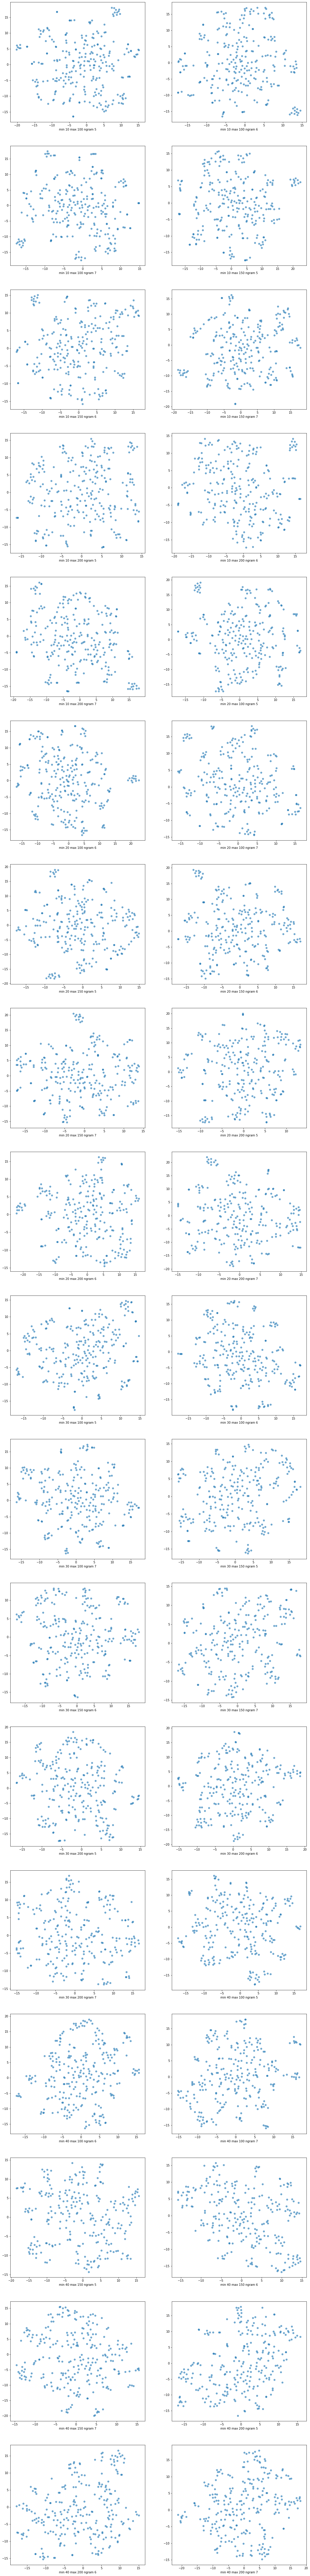

In [21]:
figrows=18
f, axes = plt.subplots(figrows, 2, figsize=(18, 160))

ind=0
for min_df in [10,20,30,40]:
    for max_df in [100, 150, 200]:
        for n_gram in [5,6,7]:
            vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=(1,n_gram))
            matrix = vectorizer.fit_transform(df.new_texts_processed_totally)
            print (matrix.shape)
            
            pca=PCA(n_components=28)
            pre_reduction = pca.fit_transform(matrix.toarray())
            tsne=manifold.TSNE(init='pca', n_iter_without_progress=250, n_iter=800, min_grad_norm=0.00001)
            trans_text=pd.DataFrame(tsne.fit_transform(pre_reduction))
                        
            print (min_df, max_df, n_gram)

            curr_ax=axes.flatten()[ind]
            curr_ax.scatter(trans_text[0], trans_text[1], s=30, alpha=0.6)
            curr_ax.set_xlabel('min '+str(min_df)+' max '+str(max_df)+' ngram '+str(n_gram))
            ind+=1
            #plt.figure(figsize=(12,12))
            #plt.scatter(trans_text[0], trans_text[1], s=2, alpha=0.05)

(261, 2130)
10 100 20
(261, 2130)
10 100 30
(261, 2130)
10 100 50
(261, 2169)
10 300 20
(261, 2169)
10 300 30
(261, 2169)
10 300 50


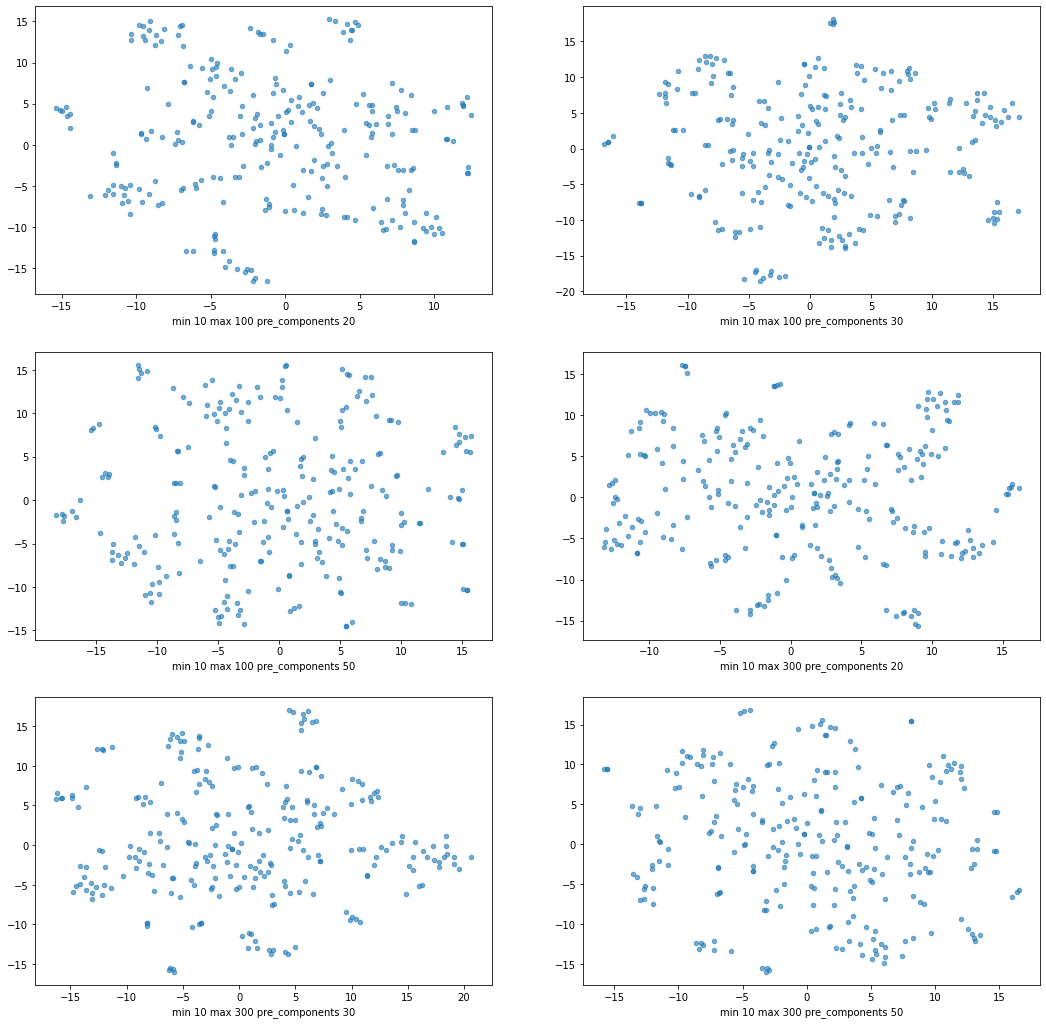

In [23]:
figrows=3
f, axes = plt.subplots(figrows, 2, figsize=(18, 18))

ind=0
for min_df in [10]:
    for max_df in [100, 300]:
        for pre_components in [20, 30, 50]:
            vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=(2,3))
            matrix = vectorizer.fit_transform(df.new_texts_processed_totally)
            print (matrix.shape)
            
            pca=PCA(n_components=pre_components)
            pre_reduction = pca.fit_transform(matrix.toarray())
            tsne=manifold.TSNE(init='pca', n_iter_without_progress=250, n_iter=800, min_grad_norm=0.00001)
            trans_text=pd.DataFrame(tsne.fit_transform(pre_reduction))
                        
            print (min_df, max_df, pre_components)

            curr_ax=axes.flatten()[ind]
            curr_ax.scatter(trans_text[0], trans_text[1], s=20, alpha=0.6)
            curr_ax.set_xlabel('min '+str(min_df)+' max '+str(max_df)+' pre_components '+str(pre_components))
            ind+=1
            #plt.figure(figsize=(12,12))
            #plt.scatter(trans_text[0], trans_text[1], s=2, alpha=0.05)

(261, 7996)
10 4 30
(261, 7996)
10 4 50
(261, 7996)
10 4 80
(261, 7996)
10 5 30
(261, 7996)
10 5 50
(261, 7996)
10 5 80
(261, 7996)
10 6 30
(261, 7996)
10 6 50
(261, 7996)
10 6 80


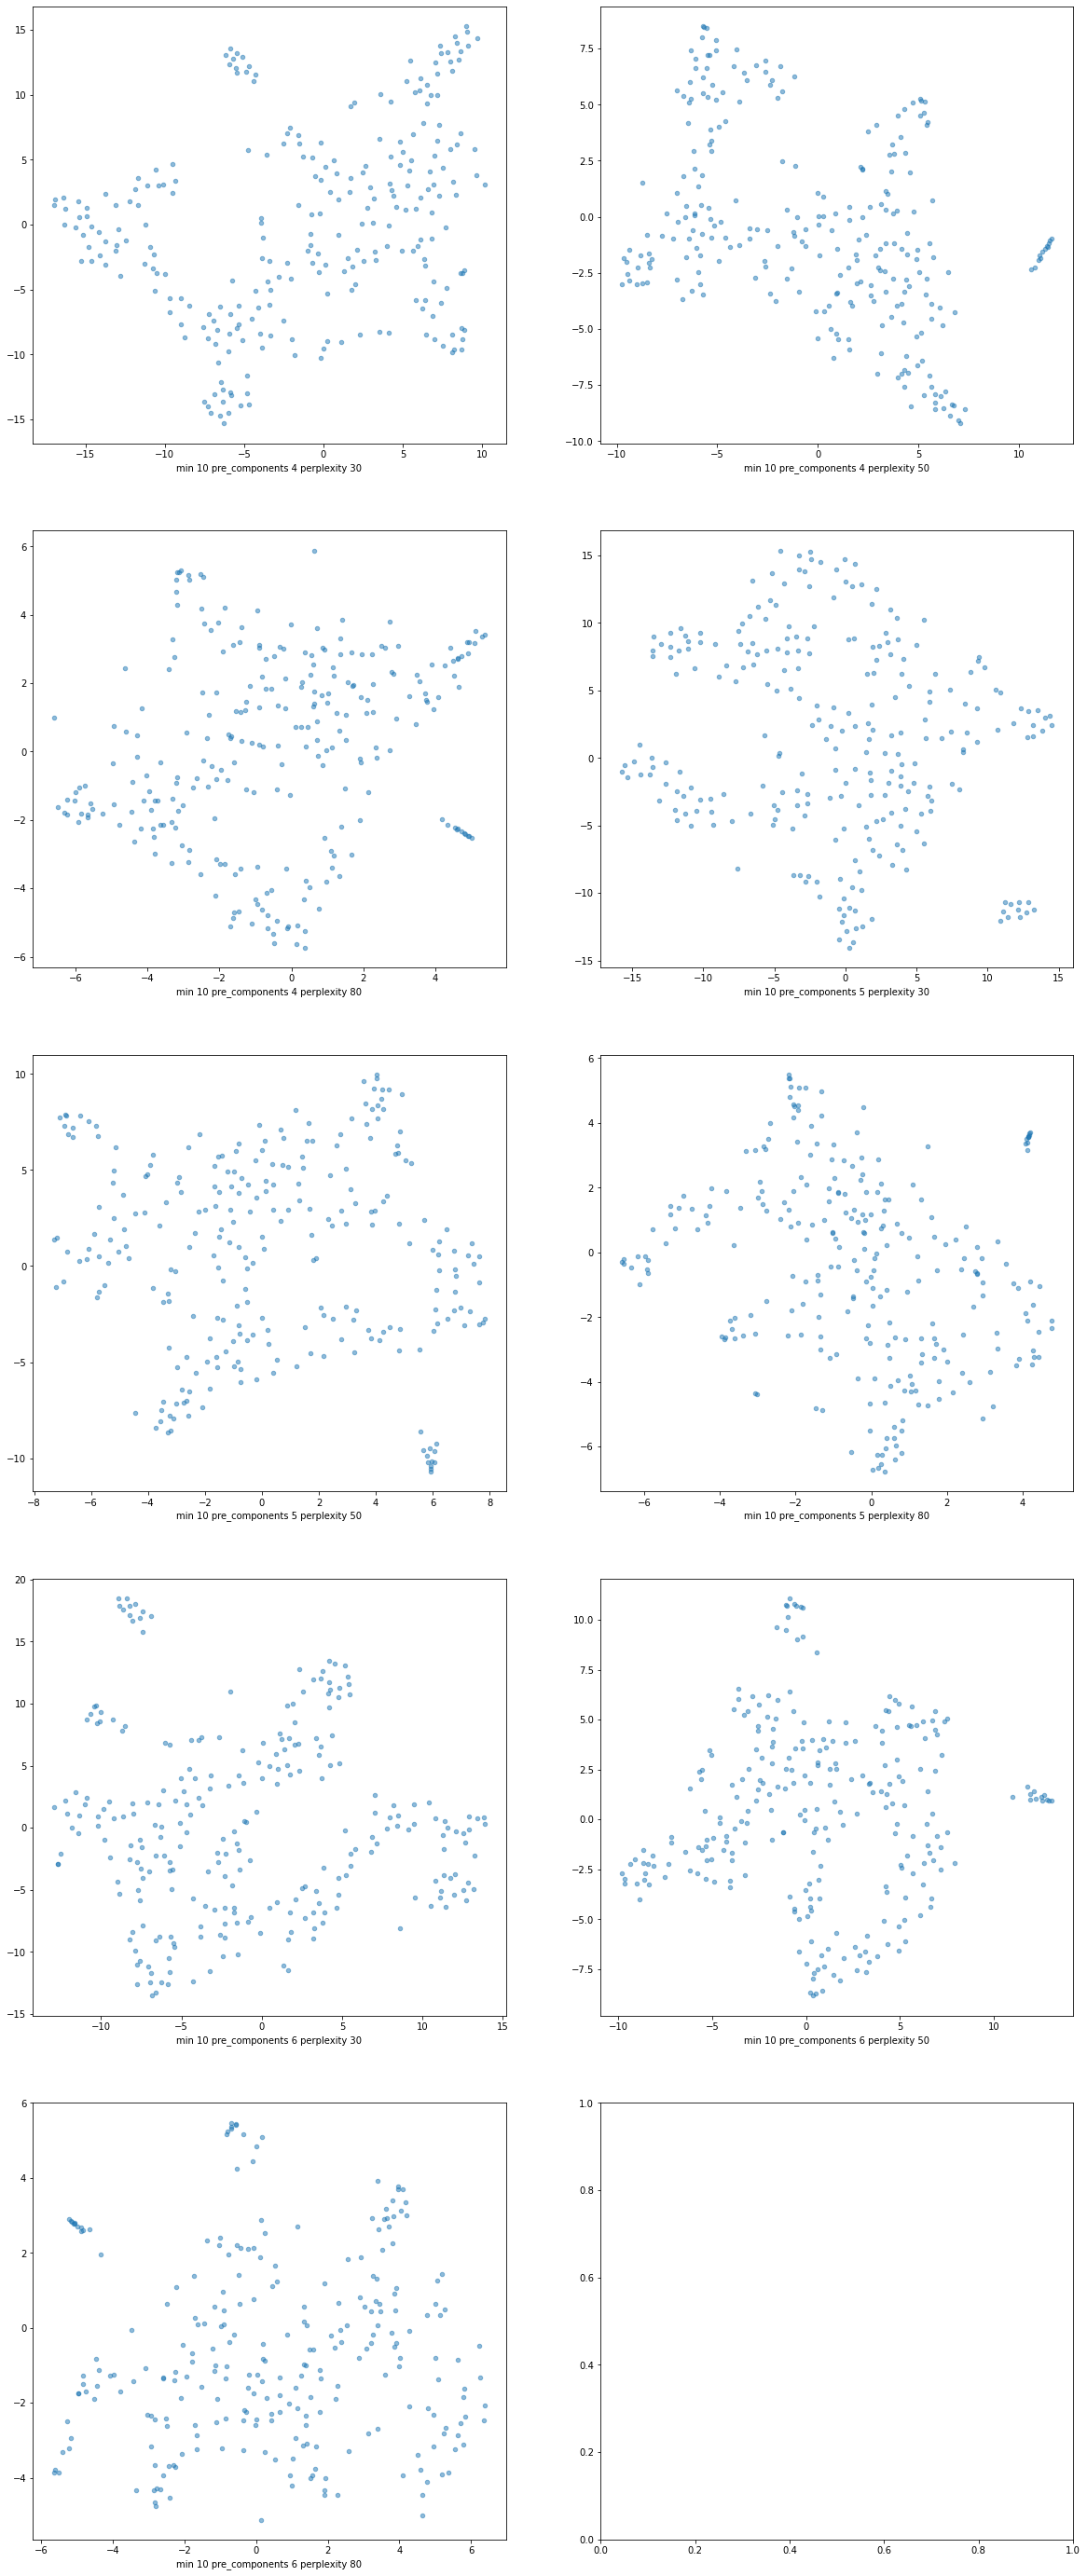

In [24]:
figrows=5
f, axes = plt.subplots(figrows, 2, figsize=(20, 50))

ind=0
for min_df in [10]:
    for pre_components in [4,5,6]:
        for perplexity in [30, 50, 80]:
            vectorizer = TfidfVectorizer(max_df=100, min_df=min_df, ngram_range=(1,5))
            matrix = vectorizer.fit_transform(df.new_texts_processed_totally)
            print (matrix.shape)
            
            pca=PCA(n_components=pre_components)
            pre_reduction = pca.fit_transform(matrix.toarray())
            tsne=manifold.TSNE(init='pca', n_iter_without_progress=250, n_iter=800, min_grad_norm=0.00001, perplexity=perplexity)
            trans_text=pd.DataFrame(tsne.fit_transform(pre_reduction))
                        
            print (min_df, pre_components, perplexity)

            curr_ax=axes.flatten()[ind]
            curr_ax.scatter(trans_text[0], trans_text[1], s=20, alpha=0.5)
            curr_ax.set_xlabel('min '+str(min_df)+' pre_components '+str(pre_components)+' perplexity '+str(perplexity))
            ind+=1
            #plt.figure(figsize=(12,12))
            #plt.scatter(trans_text[0], trans_text[1], s=2, alpha=0.05)

(261, 8456)
10 3 5
(261, 8456)
10 3 10
(261, 8456)
10 3 20
(261, 8456)
10 3 30
(261, 8456)
10 4 5
(261, 8456)
10 4 10
(261, 8456)
10 4 20
(261, 8456)
10 4 30


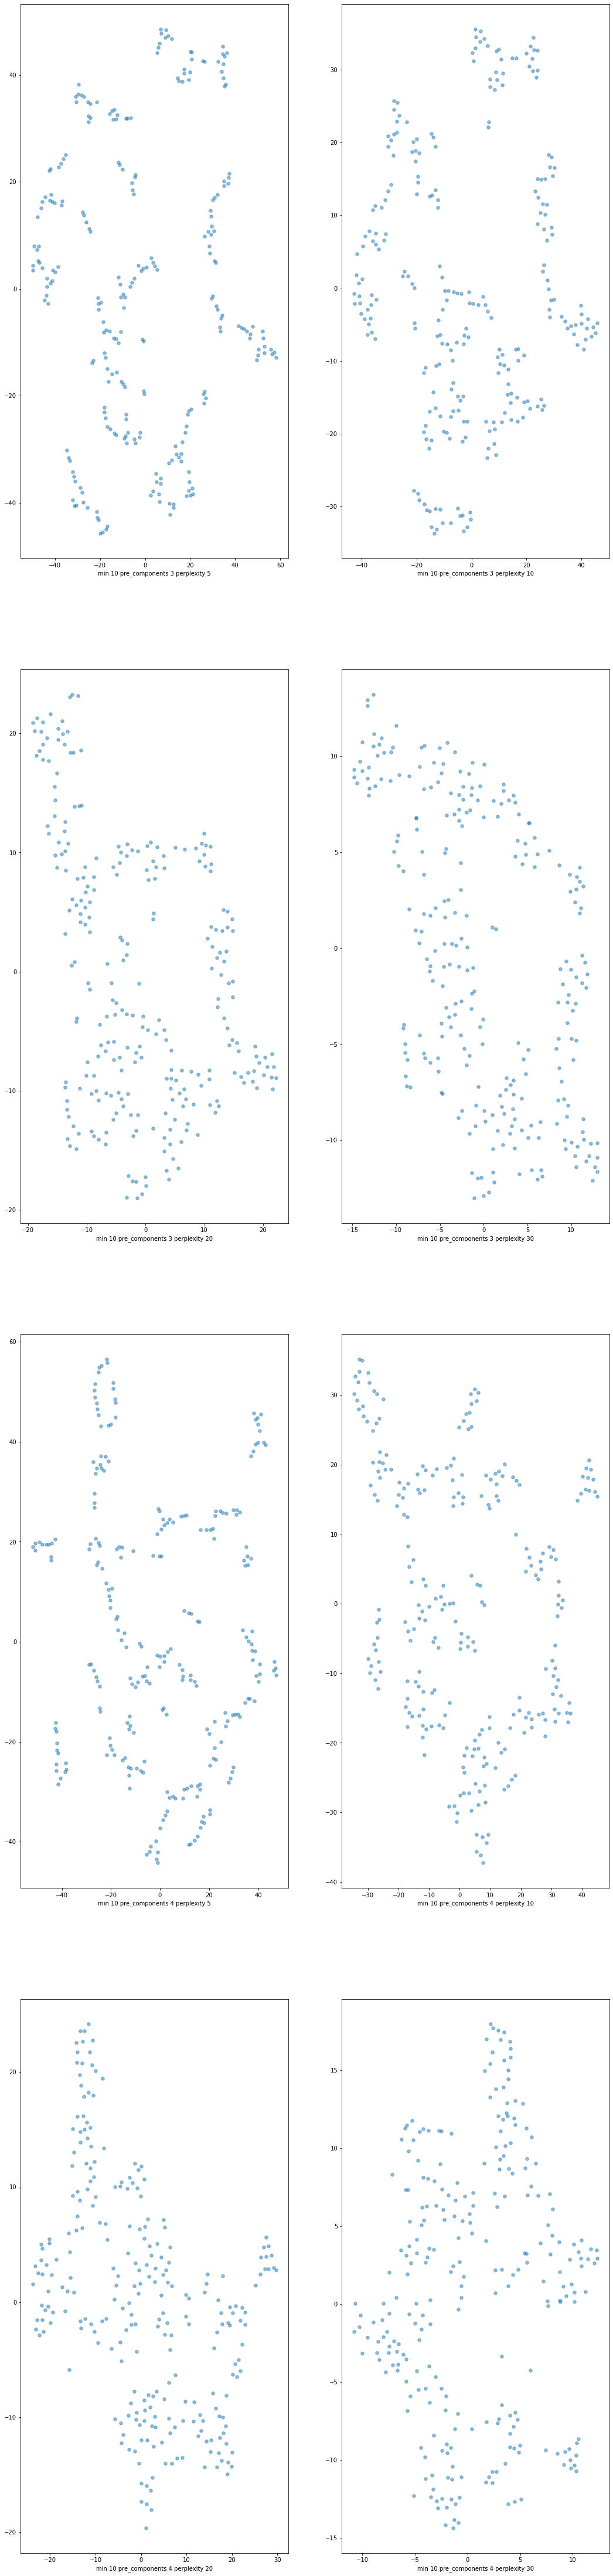

In [25]:
figrows=4
f, axes = plt.subplots(figrows, 2, figsize=(18, 80))

ind=0
for min_df in [10]:
    for pre_components in [3,4]:
        for perplexity in [5, 10, 20, 30]:
            vectorizer = TfidfVectorizer(max_df=300, min_df=min_df, ngram_range=(1,5))
            matrix = vectorizer.fit_transform(df.new_texts_processed_totally)
            print (matrix.shape)
            
            pca=PCA(n_components=pre_components)
            pre_reduction = pca.fit_transform(matrix.toarray())
            tsne=manifold.TSNE(init='pca', n_iter_without_progress=250, n_iter=800, min_grad_norm=0.00001, perplexity=perplexity)
            trans_text=pd.DataFrame(tsne.fit_transform(pre_reduction))
                        
            print (min_df, pre_components, perplexity)

            curr_ax=axes.flatten()[ind]
            curr_ax.scatter(trans_text[0], trans_text[1], s=30, alpha=0.5)
            curr_ax.set_xlabel('min '+str(min_df)+' pre_components '+str(pre_components)+' perplexity '+str(perplexity))
            ind+=1
            #plt.figure(figsize=(12,12))
            #plt.scatter(trans_text[0], trans_text[1], s=2, alpha=0.05)

In [26]:
vectorizer = TfidfVectorizer(max_df=300, min_df=30, ngram_range=(1,4))
matrix = vectorizer.fit_transform(df.new_texts_processed_totally)
results_dense = matrix.toarray()
top_terms1 = []
for row in results_dense:
    scores = []
    for term, index in vectorizer.vocabulary_.items():    
        score = row[index]
        scores.append([term, score])
    df2 = pd.DataFrame.from_records(scores, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    df2 = df2.loc[df2['score'] > 0].reset_index(drop='True')
    terms = list(df2['term'])
    if len(terms) > 5:
        terms = terms[:5]
    top_terms1.append(terms)

top_terms1

[['rice', 'blast', 'agents', 'plant', 'disease'],
 ['lactobacillus', 'expression', 'fold', 'protein', 'incubation'],
 ['milk', 'intake', 'taxa', 'biofilm', 'variables'],
 ['weeks', 'intestinal', 'lactobacillus', 'patients', 'microorganisms'],
 ['meat', 'samples', 'log', 'cfu', 'coli'],
 ['salmonella', 'prevalence', 'treatment', 'isolates', 'resistant'],
 ['salmonella', 'log', 'processed', 'coli', 'cfu'],
 ['lactic', 'acid', 'lactobacillus', 'bacteria', 'fermentation'],
 ['antioxidant', 'fraction', 'activity', 'anti inflammatory', 'methanol'],
 ['inflammatory', 'patients', 'inflammation', 'cells', 'symptoms'],
 ['sucrose', 'utilization', 'strain', 'pathway', 'glucose'],
 ['medium', 'acetate', 'sodium', 'lactobacillus', 'media'],
 ['gut', 'microbiota', 'diet', 'gut microbiota', 'abundances'],
 ['diet', 'firmicutes', 'proteobacteria', 'mini', 'phylum'],
 ['milk', 'microbiota', 'mg', 'healthy', 'bacterial'],
 ['lc', 'samples', 'areas', 'analysed', 'ion'],
 ['sub', 'reads', 'sequence', 'gen

In [27]:
len(top_terms1)

261

In [28]:
df['top_terms']=top_terms1

In [29]:
vectorizer = TfidfVectorizer(max_df=300, min_df=10, ngram_range=(1,4))
matrix = vectorizer.fit_transform(df.new_texts_processed_totally)
pca=PCA(n_components=3)
pre_reduction = pca.fit_transform(matrix.toarray())
tsne=manifold.TSNE(init='pca', n_iter_without_progress=250, n_iter=800, min_grad_norm=0.001, perplexity=10)
trans_text=pd.DataFrame(tsne.fit_transform(pre_reduction))

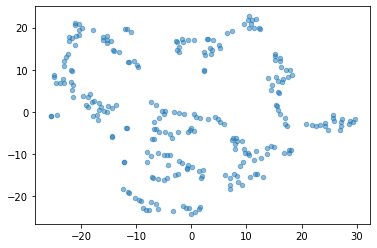

In [30]:
plt.scatter(trans_text[0], trans_text[1], s=20, alpha=0.5)

## multiclass classification

In [31]:
from scipy.stats import randint
from io import StringIO
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import ensemble, metrics 

In [32]:
from imblearn.metrics import classification_report_imbalanced

In [33]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [34]:
from sklearn.metrics import plot_confusion_matrix

In [35]:
from collections import Counter

In [36]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.naive_bayes import MultinomialNB


In [37]:
from imblearn.over_sampling import RandomOverSampler 

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
from imblearn.under_sampling import NearMiss 

In [40]:
from imblearn.combine import SMOTEENN 
from imblearn.combine import SMOTETomek 
import matplotlib.pyplot as plt

# new united dataset for training

In [51]:
df_united = pd.read_csv('training_dataset.csv')

Text(0.5, 1.0, 'Number of texts by each class')

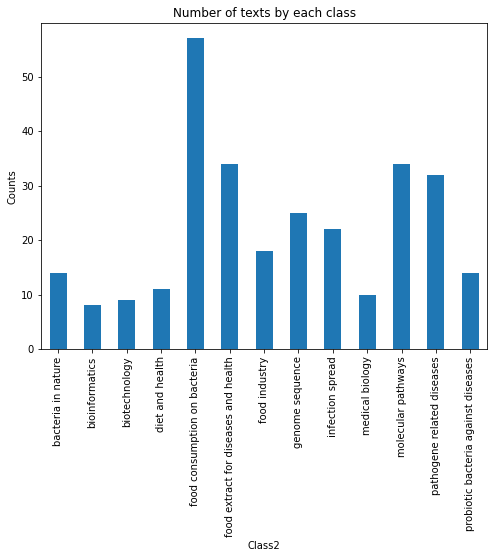

In [52]:
fig = plt.figure(figsize=(8,6))
df_united.groupby('Class2').Full_text.count().plot.bar(ylim=0)
plt.ylabel('Counts')
plt.title('Number of texts by each class')
#plt.savefig('Number of texts by each class.png', bbox_inches = 'tight')

Text(0.5, 1.0, 'Number of texts by connection')

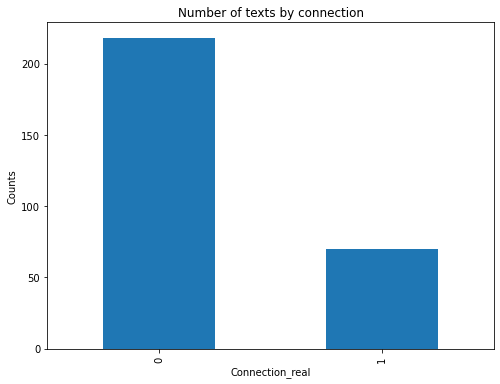

In [53]:
fig = plt.figure(figsize=(8,6))
df_united.groupby('Connection_real').Full_text.count().plot.bar(ylim=0)
plt.ylabel('Counts')
plt.title('Number of texts by connection')
#plt.savefig('Number of texts by connection.png', bbox_inches = 'tight')

In [54]:
texts2 = []
sentences2 = list(df_united["Full_text"])
for sen in sentences2:
    texts2.append(preprocess_text(sen))

In [55]:
df_united['new_texts_preprocessed']=texts2

In [56]:
df_united['new_texts_preprocessed']= df_united['new_texts_preprocessed'].map(lambda x: x.lower())

In [57]:
data2 = df_united.new_texts_preprocessed.values.tolist()

In [58]:
data_words3 = sent_to_words(data2)
data_words3 = remove_stopwords(data_words3)

In [63]:
data_words3=[' '.join(x) for x in data_words3]

In [64]:
df_united['new_texts_processed_totally']=data_words3

In [65]:
df_united['category_id'] = df_united['Class2'].factorize()[0]

In [66]:
tfidf = TfidfVectorizer(max_df=300, min_df=30, ngram_range=(1,4), stop_words='english')
features_un = tfidf.fit_transform(df_united.new_texts_processed_totally).toarray()
labels_un = df_united.category_id

In [70]:
sme = SMOTEENN(sampling_strategy='not minority')

X_res, y_res = sme.fit_resample(features_un, labels_un)
print('Original dataset shape %s' % Counter(labels_un))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({12: 57, 2: 34, 8: 34, 4: 32, 0: 25, 1: 22, 7: 18, 3: 14, 11: 14, 6: 11, 10: 10, 5: 9, 9: 8})
Resampled dataset shape Counter({5: 57, 6: 57, 10: 57, 11: 57, 3: 55, 7: 55, 1: 52, 0: 45, 8: 39, 2: 32, 4: 24, 12: 22, 9: 4})


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15)

model15 = make_pipeline_imb(RandomOverSampler(), RandomForestClassifier())

model15.fit(X_train, y_train)
y_pred15 = model15.predict(X_test)

In [72]:
print(classification_report_imbalanced(y_test, y_pred15, target_names=df_united['Class2'].unique()))

                                            pre       rec       spe        f1       geo       iba       sup

                     genome sequence       1.00      1.00      1.00      1.00      1.00      1.00        12
                    infection spread       1.00      1.00      1.00      1.00      1.00      1.00         7
                  molecular pathways       1.00      1.00      1.00      1.00      1.00      1.00         4
 probiotic bacteria against diseases       1.00      0.88      1.00      0.93      0.94      0.86         8
          pathogene related diseases       1.00      1.00      1.00      1.00      1.00      1.00         5
                       biotechnology       1.00      1.00      1.00      1.00      1.00      1.00         4
                     diet and health       1.00      1.00      1.00      1.00      1.00      1.00         8
                       food industry       0.83      1.00      0.99      0.91      0.99      0.99         5
food extract for diseases a

In [73]:
smt = SMOTETomek(random_state=42)

X_res, y_res = smt.fit_resample(features_un, labels_un)
print('Original dataset shape %s' % Counter(labels_un))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({12: 57, 2: 34, 8: 34, 4: 32, 0: 25, 1: 22, 7: 18, 3: 14, 11: 14, 6: 11, 10: 10, 5: 9, 9: 8})
Resampled dataset shape Counter({0: 57, 1: 57, 2: 57, 3: 57, 4: 57, 5: 57, 6: 57, 7: 57, 8: 57, 9: 57, 10: 57, 11: 57, 12: 57})


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=15)

model16 = RandomForestClassifier(random_state=20)

model16.fit(X_train, y_train)
y_pred16 = model16.predict(X_test)

In [75]:
print(metrics.classification_report(y_test, y_pred16, target_names=df_united['Class2'].unique()))

                                      precision    recall  f1-score   support

                     genome sequence       1.00      0.90      0.95        10
                    infection spread       0.78      1.00      0.88         7
                  molecular pathways       0.88      0.88      0.88         8
 probiotic bacteria against diseases       1.00      1.00      1.00         9
          pathogene related diseases       0.82      0.75      0.78        12
                       biotechnology       1.00      1.00      1.00         6
                     diet and health       1.00      1.00      1.00        10
                       food industry       1.00      1.00      1.00         5
food extract for diseases and health       0.89      0.80      0.84        10
                      bioinformatics       1.00      1.00      1.00        14
                     medical biology       1.00      1.00      1.00        11
                  bacteria in nature       1.00      1.00      

In [79]:
X_train, X_test, y_train, y_test = train_test_split(features_un, labels_un, test_size=0.15)

sme = SMOTEENN(sampling_strategy='not majority')

X_res, y_res = sme.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_res))
model18 = make_pipeline_imb(RandomOverSampler(), RandomForestClassifier())

model18.fit(X_res, y_res)
y_pred18 = model18.predict(X_test)

Original dataset shape Counter({12: 46, 4: 28, 2: 28, 8: 26, 1: 22, 0: 22, 7: 13, 11: 13, 3: 12, 6: 10, 5: 9, 10: 8, 9: 7})
Resampled dataset shape Counter({5: 46, 6: 46, 10: 46, 11: 46, 7: 45, 9: 45, 3: 44, 0: 33, 8: 29, 2: 26, 1: 23, 4: 19, 12: 19})


In [80]:
print(classification_report_imbalanced(y_test, y_pred18, target_names=df_united['Class2'].unique()))

                                            pre       rec       spe        f1       geo       iba       sup

                     genome sequence       1.00      0.67      1.00      0.80      0.82      0.64         3
                    infection spread       0.00      0.00      0.95      0.00      0.00      0.00         0
                  molecular pathways       0.83      0.83      0.97      0.83      0.90      0.80         6
 probiotic bacteria against diseases       0.50      1.00      0.95      0.67      0.98      0.96         2
          pathogene related diseases       0.00      0.00      0.95      0.00      0.00      0.00         4
                       biotechnology       0.00      0.00      0.98      0.00      0.00      0.00         1
                     diet and health       0.50      0.60      0.92      0.55      0.74      0.54         5
                       food industry       0.80      1.00      0.94      0.89      0.97      0.95         8
food extract for diseases a

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
features_raw = tfidf.transform(df.new_texts_processed_totally).toarray()

In [82]:
raw18 = model18.predict(features_raw)

In [83]:
raw18

array([ 8,  2,  6,  3,  1,  1,  7,  7,  8,  3,  7,  7, 12, 12,  3,  2,  0,
       12,  0,  7,  4, 12,  7, 12,  7,  3,  7,  3,  0,  8,  2,  8,  7,  0,
        3,  7,  0,  2,  0,  0, 12,  3,  0,  2,  0,  8, 12,  2,  7,  2,  1,
        2,  7,  2,  1,  1, 12, 12, 12,  0,  8,  2,  1,  8,  1,  1,  8, 12,
        0,  2,  7,  3,  0,  1, 12,  7, 12,  0,  1,  7,  1,  8,  0,  1,  8,
        2,  0,  0,  0,  1,  7,  1,  0,  2,  0,  7,  7, 12,  6,  2,  4,  2,
       11,  1,  2,  0,  8,  7,  7,  4,  2,  0, 12, 11,  3,  0,  1,  2,  8,
        0,  0,  2,  0,  2,  2,  2, 12,  3,  8,  1,  0,  0,  8,  8,  9,  7,
        0,  9,  7,  0,  4,  2,  2,  2,  8,  3,  2,  1,  0,  0,  0,  0,  2,
        2,  2,  2,  0,  0,  2,  2,  0,  2,  7,  0,  8,  3,  4,  2,  1,  1,
        0,  0,  1,  2,  2,  1,  0,  2,  2,  2,  1,  0,  8,  1,  2,  1,  1,
        0, 11,  2,  2,  2,  1,  2,  4,  2,  1,  0,  3,  0,  4,  2,  0,  7,
        0,  0,  2,  0,  0,  4,  1,  1,  1,  4,  4,  7,  1,  8,  7,  2,  7,
        2,  1,  0,  2,  2

In [84]:
raw15 = model15.predict(features_raw)

In [85]:
raw15

array([ 8,  7,  6,  3,  1,  1,  7,  7,  8,  3,  7,  7, 12, 12,  1,  1,  0,
        0, 11,  7,  1, 12,  1, 12,  7,  3,  7,  3,  0,  8,  0,  8,  7,  0,
        1,  1,  0,  1,  0,  0,  3,  3,  0,  7,  0,  8,  6,  0,  7,  1,  4,
        0,  7,  1,  1,  1,  0,  1,  1,  1,  8,  0,  1,  8,  1,  2,  8, 12,
        1,  0,  7,  3,  0,  1, 12,  7, 12,  0,  7,  7,  1,  8,  0,  1,  7,
        0,  0,  0,  0,  1,  0,  1,  7,  0,  0,  0,  7,  1,  6,  4,  1,  7,
        7,  1,  8,  0,  7,  7,  1,  1,  2,  0, 12,  2,  4,  0,  0,  2,  8,
        0,  1,  2,  7,  0,  1,  7, 12,  8,  8,  7,  0,  1,  8,  7,  2, 11,
        0,  1,  1,  0,  1,  2,  1,  2,  0,  3,  2,  1,  0,  0,  0,  0,  2,
        7,  0,  2,  0,  0,  2,  7,  0,  0,  7,  0,  1,  3,  1,  1,  1,  1,
        0,  0,  1,  2,  1,  1,  0,  0,  2,  1,  1,  0,  8,  1,  2,  1,  1,
        0, 11,  1,  1,  2,  1,  2,  1,  2,  1,  0,  3,  0,  8,  1,  0,  7,
        0,  2,  0,  0,  0,  1,  1,  2,  1,  0,  1,  1,  1,  8,  7,  7,  7,
        0,  1,  0,  2,  0

In [86]:
raw16 = model16.predict(features_raw)

In [87]:
raw16

array([ 8,  7, 12,  3,  1,  1,  4,  7,  8, 12,  2,  7, 12, 12,  4,  4,  0,
        3, 11,  7,  1, 12,  1, 12,  7, 12,  7, 12,  0,  4,  2,  8,  7,  0,
       12, 12,  0,  1,  0,  0, 12, 12,  0,  0,  0,  8, 12,  2,  0,  4,  1,
        2, 12,  2,  1,  4, 12, 12, 12,  0,  8,  2,  1,  8,  1,  1,  7, 12,
        1,  2,  4,  3,  0,  4, 12,  2, 12,  7,  4,  7,  4,  8,  0,  1,  8,
        2,  2,  0,  0,  4,  0,  1,  0,  2,  0,  0,  2,  1, 12,  4,  1,  4,
        7,  1,  8,  0,  8,  4,  7,  4,  2,  0, 12,  2,  2,  0,  4,  2,  8,
        2,  0,  2,  0,  0,  4,  2, 12,  8,  8,  7,  0,  1,  8,  7,  9, 11,
       12,  6,  4,  1,  4,  2,  4,  2,  0,  3,  0,  9,  0,  0,  0,  0,  2,
        7,  4,  2,  0,  0,  2,  1,  0,  2,  7,  0,  8, 12,  4,  1,  1,  0,
        0,  0,  1,  2,  2,  1,  2,  0,  2,  2,  1,  0,  8,  1,  2,  4,  4,
        0, 11,  2,  0,  2,  4,  2,  4,  2,  1,  0, 12, 12,  4,  2,  7,  8,
        0,  2,  2,  0,  0,  1,  0,  2,  1,  4,  1,  1,  1,  8,  7,  1,  4,
        2,  4,  0,  2,  2

In [88]:
df['model16_preds_num'] = raw16
df['model15_preds_num'] = raw15
df['model18_preds_num'] = raw18

In [89]:
df['model16_preds_names'] = df['model16_preds_num']
df['model15_preds_names'] = df['model15_preds_num']
df['model18_preds_names'] = df['model18_preds_num']

In [90]:
category_id_df1 = df_united[['Class2', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id1 = dict(category_id_df1.values)

In [91]:
category_to_id1

{'genome sequence': 0,
 'infection spread': 1,
 'molecular pathways': 2,
 'probiotic bacteria against diseases': 3,
 'pathogene related diseases': 4,
 'biotechnology': 5,
 'diet and health': 6,
 'food industry': 7,
 'food extract for diseases and health': 8,
 'bioinformatics': 9,
 'medical biology': 10,
 'bacteria in nature': 11,
 'food consumption on bacteria': 12}

In [92]:
id_to_category = dict(category_id_df1[['category_id', 'Class2']].values)

In [93]:
id_to_category

{0: 'genome sequence',
 1: 'infection spread',
 2: 'molecular pathways',
 3: 'probiotic bacteria against diseases',
 4: 'pathogene related diseases',
 5: 'biotechnology',
 6: 'diet and health',
 7: 'food industry',
 8: 'food extract for diseases and health',
 9: 'bioinformatics',
 10: 'medical biology',
 11: 'bacteria in nature',
 12: 'food consumption on bacteria'}

In [94]:
df = df.replace({"model16_preds_names": id_to_category})

In [95]:
df = df.replace({"model18_preds_names": id_to_category})

In [96]:
df = df.replace({"model15_preds_names": id_to_category})

# connection prediction

In [97]:
df_united.columns

Index(['PMC', 'counts', 'Class', 'Class2', 'Connection_real', 'Abstract',
       'Full_text', 'Intro', 'new_texts_preprocessed',
       'new_texts_processed_totally', 'category_id'],
      dtype='object')

Text(0.5, 1.0, 'Connection distribution')

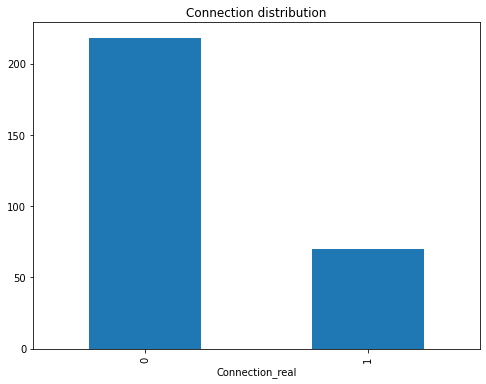

In [98]:
fig = plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 10
df_united.groupby('Connection_real').Full_text.count().plot.bar(ylim=0)
plt.title('Connection distribution')

In [99]:
import xgboost as xgb

In [100]:
labels_connection = df_united.Connection_real

In [101]:
X_train, X_test, y_train, y_test = train_test_split(features_un, labels_connection, test_size=0.15)

sme = SMOTEENN(sampling_strategy='not majority')

X_res, y_res = sme.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_res))
model_con1 = make_pipeline_imb(RandomOverSampler(), RandomForestClassifier())

model_con1.fit(X_res, y_res)
y_pred_con1 = model_con1.predict(X_test)

Original dataset shape Counter({0: 185, 1: 59})
Resampled dataset shape Counter({1: 180, 0: 65})


In [103]:
print(classification_report_imbalanced(y_test, y_pred_con1))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.97      0.82      0.96      0.89      0.81        33
          1       0.90      0.82      0.97      0.86      0.89      0.78        11

avg / total       0.93      0.93      0.86      0.93      0.89      0.80        44



In [104]:
model_con2 = make_pipeline_imb(RandomOverSampler(), xgb.XGBClassifier(n_estimators=20))

model_con2.fit(X_res, y_res)
y_pred_con2 = model_con2.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [105]:
print(classification_report_imbalanced(y_test, y_pred_con2))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.97      0.91      0.97      0.94      0.89        33
          1       0.91      0.91      0.97      0.91      0.94      0.88        11

avg / total       0.95      0.95      0.92      0.95      0.94      0.88        44



In [106]:
sme = SMOTEENN(sampling_strategy='not minority')


In [107]:
X_train, X_test, y_train, y_test = train_test_split(features_un, labels_connection, test_size=0.15)

X_res, y_res = sme.fit_resample(X_train, y_train)
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_res))
model_con3 = make_pipeline_imb(RandomOverSampler(), RandomForestClassifier())

model_con3.fit(X_train, y_train)
y_pred_con3 = model_con3.predict(X_test)

Original dataset shape Counter({0: 187, 1: 57})
Resampled dataset shape Counter({0: 142, 1: 37})


In [108]:
print(classification_report_imbalanced(y_test, y_pred_con3))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.97      0.77      0.94      0.86      0.76        31
          1       0.91      0.77      0.97      0.83      0.86      0.73        13

avg / total       0.91      0.91      0.83      0.91      0.86      0.75        44



In [109]:
raw_con1 = model_con1.predict(features_raw)

In [110]:
raw_con1

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [111]:
raw_con2 = model_con2.predict(features_raw)

In [112]:
raw_con2

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [113]:
raw_con3 = model_con3.predict(features_raw)

In [114]:
raw_con3

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [115]:
df['model1_preds_connection'] = raw_con1
df['model2_preds_connection'] = raw_con2
df['model3_preds_connection'] = raw_con3

In [116]:
df2=df.drop(['new_texts_preprocessed', 'new_texts_processed_totally', 'Full_text','Unnamed: 0'], axis=1)

In [117]:
df2

,PMC,top_terms,model16_preds_num,model15_preds_num,model18_preds_num,model16_preds_names,model15_preds_names,model18_preds_names,model1_preds_connection,model2_preds_connection,model3_preds_connection
0,5239798,"[rice, blast, agents, plant, disease]",8,8,8,food extract for diseases and health,food extract for diseases and health,food extract for diseases and health,0,0,0
1,5218481,"[lactobacillus, expression, fold, protein, inc...",7,7,2,food industry,food industry,molecular pathways,0,1,0
2,5862454,"[milk, intake, taxa, biofilm, variables]",12,6,6,food consumption on bacteria,diet and health,diet and health,1,1,1
3,5622781,"[weeks, intestinal, lactobacillus, patients, m...",3,3,3,probiotic bacteria against diseases,probiotic bacteria against diseases,probiotic bacteria against diseases,1,1,0
4,5806876,"[meat, samples, log, cfu, coli]",1,1,1,infection spread,infection spread,infection spread,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
256,5682260,"[coli, resistance, isolates, antibiotic, antib...",4,1,4,pathogene related diseases,infection spread,pathogene related diseases,0,0,0
257,5741668,"[derivatives, ng, gc, compounds, threshold]",8,7,1,food extract for diseases and health,food industry,infection spread,0,0,0
258,5770358,"[wheat, kg, expression, sections, supplementary]",0,2,0,genome sequence,molecular pathways,genome sequence,0,0,0
259,5600385,"[cd, responses, cells, coli, recombinant]",2,1,1,molecular pathways,infection spread,infection spread,0,0,0


In [ ]:
df3 = pd.read_csv('all_potential_matches.csv', index_col=0)

In [ ]:
df3['PMC'] = df3['PMC'].astype('int64')

In [ ]:
final_output = df3.merge(df2, how='inner', on='PMC')

In [ ]:
final_output.to_csv('final_output.csv')